# Veremos como hacer subplots diversos

In [11]:
from siphon.catalog import TDSCatalog
import numpy as np

Como ya habiamos hecho el script inicial ahora vamos a trabajar con una funcion mas sencilla

In [12]:
def get_gfs_espacial(b_url, id_url=0, lonlat=None, nivel=100000, tiempo=None, variables=None):
    ''''
    b_url: url del catalogo
    id_url: posición del producto deseado
    lonlat: lista con la posicion de las esquina superior izquierda e inferior derecha
            [lon_min, lat_max, lon_max, lat_min]
    tiempo: tiempo en hora UTC para la data requerida
    *variables: variables objetivo
    '''
    # define el tiempo por defecto
    from datetime import datetime, timedelta, timezone
    t_in = datetime.now(timezone.utc)
    t_fin = datetime.now(timezone.utc)

    if lonlat is None:
        lonlat = [270, 5, 300, -25]
    if variables is None:
        variables = ['Temperature_isobaric']

    best = TDSCatalog(b_url)
    best_ds = best.datasets[id_url]
    ncss =best_ds.subset()
    query = ncss.query()
    if tiempo is None:
        query.lonlat_box(west=lonlat[0], north=lonlat[1], east=lonlat[2], south=lonlat[3]).vertical_level(nivel).time_range(t_in, t_fin)
    else:
        query.lonlat_box(west=lonlat[0], north=lonlat[1], east=lonlat[2], south=lonlat[3]).vertical_level(nivel).time_range(tiempo[0], tiempo[1])
    query.accept('netcdf4')
    query.variables(*variables)

    # haciendo el requerimiento de los datos
    data = ncss.get_data(query)
    from xarray.backends import NetCDF4DataStore
    import xarray as xr

    return xr.open_dataset(NetCDF4DataStore(data))




Ahora trabajemos con nuestra nueva función

In [13]:
from datetime import datetime, timedelta, timezone

url = 'http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml'
lon_lat = [270, 0, 300, -20]

t_incial = datetime.now(timezone.utc)
t_final = t_incial + timedelta(hours=3)
tiempo_obj = (t_incial, t_final)

variables_int = ['Temperature_isobaric', 
                'Relative_humidity_isobaric', 
                'u-component_of_wind_isobaric', 
                'v-component_of_wind_isobaric']

data_gfs  = get_gfs_espacial(url, lonlat=lon_lat, tiempo=tiempo_obj, variables=variables_int)


In [14]:

data_gfs

<xarray.Dataset>
Dimensions:                        (reftime: 1, time: 2, latitude: 81,
                                    isobaric: 1, longitude: 121)
Coordinates:
  * reftime                        (reftime) datetime64[ns] 2022-10-26T12:00:00
    timeForecast                   (time) datetime64[ns] ...
  * latitude                       (latitude) float32 0.0 -0.25 ... -19.75 -20.0
  * time                           (time) datetime64[ns] 2022-10-26T18:00:00 ...
  * isobaric                       (isobaric) float64 1e+05
  * longitude                      (longitude) float32 270.0 270.2 ... 300.0
Data variables:
    Relative_humidity_isobaric     (reftime, time, isobaric, latitude, longitude) float32 ...
    Temperature_isobaric           (reftime, time, isobaric, latitude, longitude) float32 ...
    u-component_of_wind_isobaric   (reftime, time, isobaric, latitude, longitude) float32 ...
    v-component_of_wind_isobaric   (reftime, time, isobaric, latitude, longitude) float32 ...
    LatLon_721X1440-0p13S-180p00E  int32 ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    ...                                                                                ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

In [15]:
# vamos a trabajar la longitud con -360, el modelo retorno de 0 a 360
lon = data_gfs.longitude.data - 360
lat = data_gfs.latitude.data
T = data_gfs.Temperature_isobaric.data[0,:,0] # temperatura en kelvin
U = data_gfs['u-component_of_wind_isobaric'].data[0,:,0]  # velocida en m/s
V = data_gfs['v-component_of_wind_isobaric'].data[0,:,0] # velocida en m/s

# generando los puntos para graficar
lon, lat = np.meshgrid(lon, lat)

In [16]:
U.shape

(2, 81, 121)

## Plot y subplot

Ahora vemos que podemos hacer para los gráficos

In [17]:
from matplotlib import pyplot as plt

from cartopy import feature as cf
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader as ShapeReader, natural_earth

import cmaps
import geocat.viz as gv

In [18]:
def make_plot_conf(lon, lat, T, fig, subp, projection=None):
    if projection is None:
        projection = ccrs.PlateCarree()

    # niveles de temperatura
    clevs = np.linspace(10, 45, 14)

    # en mi caso retorna un problema de existencia de la paleta de colores
    try:
        cmap = cmaps.MPL_jet

        # Importando la base del colormap para trabajar
        newcmp = gv.truncate_colormap(cmap,
                                minval=0.1,
                                maxval=0.6,
                                n=len(clevs))
    except ValueError:
        newcmp = plt.cm.jet 
    
    # definiendo las dimensiones y proyección de la nueva figura
    ax= fig.add_subplot(subp[0], subp[1], subp[2], projection=projection)

    ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=projection)
    ax.coastlines('50m', linewidth=0.8)
    ax.add_feature(cf.BORDERS, edgecolor="yellow")
    ax.add_feature(cf.COASTLINE, edgecolor="yellow")

    # gráfico de contorno relleno de la temperatura
    c_f = ax.contourf(lon, lat, T, levels=clevs, cmap=newcmp, zorder=1)

    # colocando la barra de colores en modo horizontal
    cax = plt.axes((0.14, 0.2, 0.74, 0.02))
    cbar = plt.colorbar(c_f,
                    ax=ax,
                    cax=cax,
                    ticks=clevs[1:-1],
                    drawedges=True,
                    orientation='horizontal')
    cbar.ax.tick_params(labelsize=12, rotation=45)

    # definimos las caracteristicas de los "ticks"
    gv.set_axes_limits_and_ticks(ax,
                            xticks=np.linspace(lon.min(), lon.max(), 5),
                            yticks=np.linspace(lat.min(), lat.max(), 5))

    # Adicion de las latitudes y longitudes correspondientes
    gv.add_lat_lon_ticklabels(ax)

    # configuración de los "ticks" mayores y menores
    gv.add_major_minor_ticks(ax,
                            x_minor_per_major=4,
                            y_minor_per_major=5,
                            labelsize=14)
    return ax



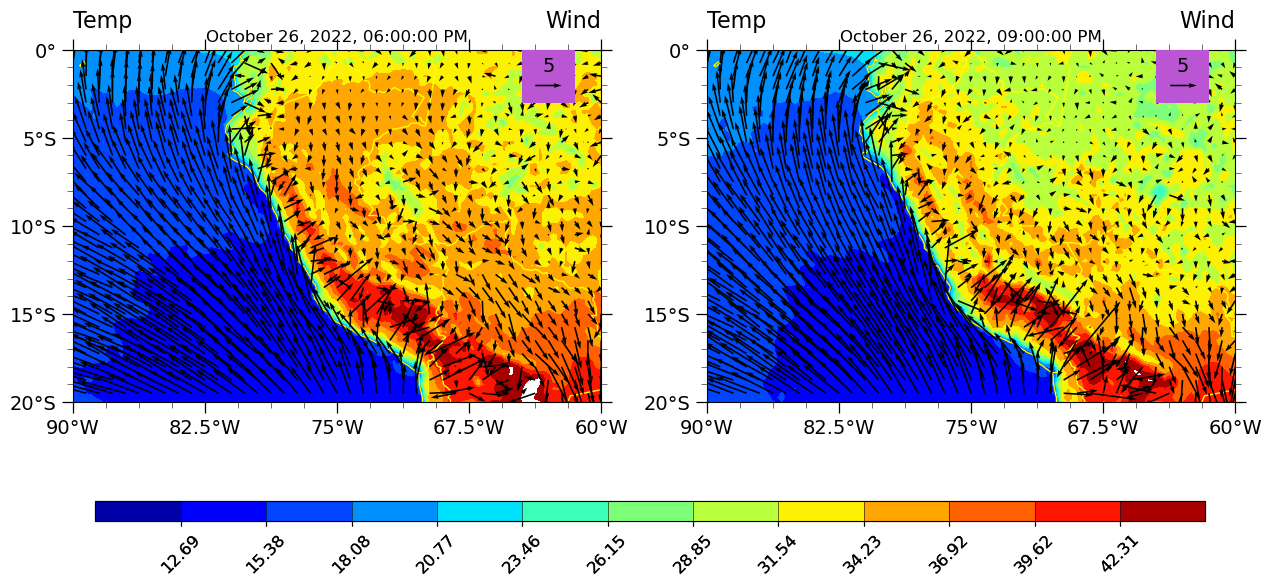

In [19]:
fig = plt.figure(figsize=(15, 10))
subp = [1, 2, 1]
ax_1 = make_plot_conf(fig=fig, subp=subp, lon=lon, lat=lat, T=T[0])
# Definiendo las características de las flechas
Q = ax_1.quiver(lon[::3,::3],
        lat[::3,::3],
        U[0,::3,::3],
        V[0,::3,::3],
        color='black',
        width=.003,
        scale=100.,
        headwidth=3.,
        zorder=4)

# Dibujo del cuadro del vector de velocidad de referencia
rect = plt.Rectangle((-64.5, -3),
                3,
                3,
                facecolor='mediumorchid',
                edgecolor=None,
                zorder=4)
ax_1.add_patch(rect)
ax_1.quiverkey(Q,
        0.9,
        0.9,
        5,
        '5',
        labelpos='N',
        color='black',
        coordinates='axes',
        fontproperties={'size': 14},
        labelsep=0.1)

# Colocando titulos a conveniencia
gv.set_titles_and_labels(ax_1,
                        lefttitle="Temp",
                        lefttitlefontsize=16,
                        righttitle="Wind",
                        righttitlefontsize=16)

# tener cuidado con la variable de tiempo, no siempre se guarda en la misma variable
# puede ser reftime, validtime2....
ax_1.set_title(f"{data_gfs.time[0].dt.strftime('%B %d, %Y, %r').data}")

subp = [1, 2, 2]
ax_2 = make_plot_conf(lon=lon, lat=lat, fig=fig, subp=subp, T=T[1])
# Definiendo las características de las flechas
Q = ax_2.quiver(lon[::3,::3],
        lat[::3,::3],
        U[1,::3,::3],
        V[1,::3,::3],
        color='black',
        width=.003,
        scale=100.,
        headwidth=3.,
        zorder=4)

# Dibujo del cuadro del vector de velocidad de referencia
rect = plt.Rectangle((-64.5, -3),
                3,
                3,
                facecolor='mediumorchid',
                edgecolor=None,
                zorder=4)
ax_2.add_patch(rect)
ax_2.quiverkey(Q,
        0.9,
        0.9,
        5,
        '5',
        labelpos='N',
        color='black',
        coordinates='axes',
        fontproperties={'size': 14},
        labelsep=0.1)

# Colocando titulos a conveniencia
gv.set_titles_and_labels(ax_2,
                        lefttitle="Temp",
                        lefttitlefontsize=16,
                        righttitle="Wind",
                        righttitlefontsize=16)
                        
ax_2.set_title(f"{data_gfs.time[1].dt.strftime('%B %d, %Y, %r').data}")
# mostrar el gráfico final
plt.show()

In [20]:
data_gfs.validtime2[0].dt.strftime('%B %d, %Y, %r').data

AttributeError: 'Dataset' object has no attribute 'validtime2'

In [ ]:
data_gfs.vali

(2, 81, 121)